In [63]:
import pandas as pd
df = pd.read_csv("relativeLengths.csv").set_index("Names")
print(df)
print(df["Index"].sum())
print(df["Index"].iloc[3])

             Index  Middle   Third  Fourth
Names                                     
METATOBASE  132.59  132.59  132.59  132.59
PIPTOMETA    30.19   33.22   28.72   22.89
DIPPIP       29.22   32.97   29.25   21.30
ENDDIP       31.95   33.81   33.84   30.70
223.95
31.95


In [1]:
import pyvista as pv
import numpy as np

topRadii = 4
bottomRadii = 3
fingerBodyHeight = 4
fingerBodyWidth = 6
fingerBodyLength = 10
resolution = 9
holeRadius = 0.5

def generateFingerPart(resolution, topRadii, bottomRadii, fingerBodyHeight, fingerBodyWidth, holeRadius, fingerBodyLength):
    def endFace(resolution, topRadii, bottomRadii, fingerBodyHeight, fingerBodyWidth, holeRadius):
        newPoints = []
        faces = []
        thetaInterval = np.pi/(resolution)
        for i in range(2):
            batch = []
            theta = 0
            while theta < np.pi/2:
                radius = fingerBodyWidth/2/np.cos(theta) 
                while radius*np.sin(theta)<fingerBodyHeight/2-bottomRadii:
                    batch.append((radius*np.cos(theta)*((-1)**i), -radius*np.sin(theta), 0))
                    theta += thetaInterval
                    radius = fingerBodyWidth/2/np.cos(theta) 
                while radius*np.sin(theta)<fingerBodyHeight/2:
                    batch.append((radius*np.cos(theta)*((-1)**i), -radius*np.sin(theta), 0))
                    theta += thetaInterval
                radius = fingerBodyHeight/2/np.sin(theta)  
                while radius*np.cos(theta)>0:
                    batch.append((radius*np.cos(theta)*((-1)**i), -radius*np.sin(theta), 0))
                    theta += thetaInterval  
                    radius = fingerBodyHeight/2/np.sin(theta)
            if i%2==1:
                batch.reverse()
                batch.pop(0)
            newPoints.extend(batch)  
        newPoints.pop(0)
        newPoints.pop()
        newPoints.append((0,0,0))
        for p in range(len(newPoints)-1):
            faces.append((3, p, len(newPoints)-1, p+1))
        for i in range(2):
            batch = []
            theta = 0
            while theta < np.pi/2:
                radius = fingerBodyWidth/2/np.cos(theta) 
                while radius*np.sin(theta)<fingerBodyHeight/2-topRadii:
                    batch.append((radius*np.cos(theta)*((-1)**i), radius*np.sin(theta), radius*np.sin(theta)))
                    theta += thetaInterval
                    radius = fingerBodyWidth/2/np.cos(theta) 
                while radius*np.sin(theta)<fingerBodyHeight/2:
                    batch.append((radius*np.cos(theta)*((-1)**i), radius*np.sin(theta), radius*np.sin(theta)))
                    theta += thetaInterval
                radius = fingerBodyHeight/2/np.sin(theta)  
                while radius*np.cos(theta)>0:
                    batch.append((radius*np.cos(theta)*((-1)**i), radius*np.sin(theta), radius*np.sin(theta)))
                    theta += thetaInterval  
                    radius = fingerBodyHeight/2/np.sin(theta)  
            if i%2==1:
                batch.reverse()
                batch.pop(0)
            newPoints.extend(batch)
        for i in range(resolution+1):
            theta = 2*np.pi/resolution*i+(3*np.pi/2)
            newPoints.append((holeRadius*np.cos(theta), holeRadius*np.sin(theta)+fingerBodyHeight/4, holeRadius*np.sin(theta)+fingerBodyHeight/4)) 
        offset = resolution-2
        faces.append((3, offset-1, offset, resolution+offset))
        faces.append((3, 0, offset, offset+1))
        for i in range(resolution+1):
            faces.append((3, i+offset, (i+1)%(resolution+1)+offset, (i)%(resolution+1)+resolution+offset+1))
            faces.append((3, (i)%(resolution+1)+resolution+offset+1, (i+1)%(resolution+1)+resolution+offset+1, (i+1)%(resolution+1)+offset))
        return (np.array(newPoints), faces)

    faces = []
    totalVertices = []
    frontVertices, facesFront = endFace(resolution=resolution, topRadii=topRadii, bottomRadii=bottomRadii, fingerBodyHeight=fingerBodyHeight, fingerBodyWidth=fingerBodyWidth, holeRadius=holeRadius)
    backVertices, facesBack = endFace(resolution=resolution, topRadii=topRadii, bottomRadii=bottomRadii, fingerBodyHeight=fingerBodyHeight, fingerBodyWidth=fingerBodyWidth, holeRadius=holeRadius)
    adjustedFrontFaceVertices = []
    for vertice in frontVertices:
        adjustedFrontFaceVertices.append((vertice[0], vertice[1], vertice[2]-fingerBodyLength/2))
    totalVertices.extend(adjustedFrontFaceVertices)
    faces.extend(facesFront)
    adjustedBackFaceVertices = []
    for vertice in backVertices:
        adjustedBackFaceVertices.append((vertice[0], vertice[1], -1*vertice[2]+fingerBodyLength/2))
    adjustedBackFaces = []
    for idx in range(len(facesBack)):
        newFace = (3, facesBack[idx][1]+len(frontVertices), facesBack[idx][2]+len(frontVertices), facesBack[idx][3]+len(frontVertices))
        adjustedBackFaces.append(newFace)
    totalVertices.extend(adjustedBackFaceVertices)
    faces.extend(adjustedBackFaces)
    for idx in range(resolution-3):
        faces.append([3, idx, idx+1, idx+len(frontVertices)])
        faces.append([3, idx+len(frontVertices), idx+len(frontVertices)+1, idx+1])
    offset = resolution-1
    for idx in range(resolution-1):
        faces.append([3, idx+offset, idx+offset+1, idx+offset+len(frontVertices)])
        faces.append([3, idx+offset+len(frontVertices), idx+offset+len(frontVertices)+1, idx+offset+1])

    faces.append([3, 0, len(frontVertices), len(frontVertices)+resolution-1])
    faces.append([3, 0, len(frontVertices)+resolution-1, resolution-1])
    faces.append([3, resolution-3, len(frontVertices)+resolution-3, len(frontVertices)+resolution+resolution-2])
    faces.append([3, resolution-3, len(frontVertices)+resolution+resolution-2, resolution+resolution-2])

    offset = resolution+resolution-1
    for i in range(resolution+1):
        faces.append([3, offset+i, offset+((i+1)%(resolution+1)), len(frontVertices)+offset+(i%(resolution+1))])
        faces.append([3, offset+((i+1)%(resolution+1)), len(frontVertices)+offset+(i%(resolution+1)), len(frontVertices)+offset+((i+1)%(resolution+1))])
    mesh = pv.PolyData(totalVertices, faces).triangulate()
    return mesh

def move_and_align_mesh(mesh, new_center, new_align_vector, new_normal):
    otherNormal = np.cross(new_align_vector, new_normal)
    transformation_matrix = np.eye(4)
    A = [new_align_vector/np.linalg.norm(new_align_vector), new_normal/np.linalg.norm(new_normal), otherNormal/np.linalg.norm(otherNormal)]
    transformation_matrix[0:3, 0:3] =np.linalg.inv(A)
    mesh = mesh.transform(transformation_matrix)
    translation_vector = new_center - np.array([0,0,0], dtype=float)
    mesh = mesh.translate(translation_vector)
    return mesh

thingy = generateFingerPart(resolution=resolution, topRadii=topRadii, bottomRadii=bottomRadii, fingerBodyHeight=fingerBodyHeight, fingerBodyWidth=fingerBodyWidth, holeRadius=holeRadius, fingerBodyLength=fingerBodyLength)
# thingy = move_and_align_mesh(thingy, np.array([0,0,0], dtype=float), np.array([1,1,0], dtype=float), np.array([1,0,3], dtype=float))
oldThingy = generateFingerPart(resolution=resolution, topRadii=topRadii, bottomRadii=bottomRadii, fingerBodyHeight=fingerBodyHeight, fingerBodyWidth=fingerBodyWidth, holeRadius=holeRadius, fingerBodyLength=fingerBodyLength)

pl = pv.Plotter()
pl.add_mesh(thingy)
pl.add_mesh(oldThingy)
pl.show()

Widget(value="<iframe src='http://localhost:53052/index.html?ui=P_0x217b11bb3d0_0&reconnect=auto' style='width…

In [2]:
import pyvista as pv
import numpy as np

topRadii = 1
bottomRadii = 1
fingerBodyHeight = 6
fingerBodyWidth = 7
proximalLength = 9
distalLength = 12
resolution = 9
holeRadius = 0.5

def generateFingerPart(resolution, topRadii, bottomRadii, fingerBodyHeight, fingerBodyWidth, holeRadius, PIP, DIP, end):
    def endFace(resolution, topRadii, bottomRadii, fingerBodyHeight, fingerBodyWidth, holeRadius, angleBottom, angleTop, center):
        if resolution%2!=1:
            print("Resolution must be an odd number")
            return None
        newPoints = []
        faces = []
        thetaInterval = np.pi/(resolution)
        for i in range(2):
            batch = []
            theta = 0
            while theta < np.pi/2:
                radius = fingerBodyWidth/2/np.cos(theta) 
                while radius*np.sin(theta)<fingerBodyHeight/2-bottomRadii:
                    if np.tan(angleBottom) == 0:
                        batch.append((radius*np.cos(theta)*((-1)**i)+center[0], -radius*np.sin(theta)+center[1], center[2]))
                    else:
                        batch.append((radius*np.cos(theta)*((-1)**i)+center[0], -radius*np.sin(theta)+center[1],-radius*np.sin(theta)/np.tan(angleBottom)+center[2]))
                    theta += thetaInterval
                    radius = fingerBodyWidth/2/np.cos(theta) 
                while radius*np.sin(theta)<fingerBodyHeight/2:
                    if np.tan(angleBottom) == 0:
                        batch.append((radius*np.cos(theta)*((-1)**i)+center[0], -radius*np.sin(theta) + center[1], center[2]))
                    else:
                        batch.append((radius*np.cos(theta)*((-1)**i)+center[0], -radius*np.sin(theta) + center[1], -radius*np.sin(theta)/np.tan(angleBottom)+center[2]))
                    theta += thetaInterval
                radius = fingerBodyHeight/2/np.sin(theta)  
                while radius*np.cos(theta)>0:
                    if np.tan(angleBottom)==0:
                        batch.append((radius*np.cos(theta)*((-1)**i)+center[0], -radius*np.sin(theta) + center[1], center[2]))
                    else:
                        batch.append((radius*np.cos(theta)*((-1)**i)+center[0], -radius*np.sin(theta) + center[1], -radius*np.sin(theta)/np.tan(angleBottom)+center[2]))
                    theta += thetaInterval  
                    radius = fingerBodyHeight/2/np.sin(theta)
            if i%2==1:
                batch.reverse()
                batch.pop(0)
            newPoints.extend(batch)  
        newPoints.pop(0)
        newPoints.pop()
        newPoints.append(center)
        for p in range(len(newPoints)-1):
            faces.append((3, p, len(newPoints)-1, p+1))
        for i in range(2):
            batch = []
            theta = 0
            while theta < np.pi/2:
                radius = fingerBodyWidth/2/np.cos(theta) 
                while radius*np.sin(theta)<fingerBodyHeight/2-topRadii:
                    batch.append((radius*np.cos(theta)*((-1)**i)+center[0], radius*np.sin(theta)+center[1], radius*np.sin(theta)/np.tan(angleTop)+center[2]))
                    theta += thetaInterval
                    radius = fingerBodyWidth/2/np.cos(theta) 
                while radius*np.sin(theta)<fingerBodyHeight/2:
                    batch.append((radius*np.cos(theta)*((-1)**i)+center[0], radius*np.sin(theta)+center[1], radius*np.sin(theta)/np.tan(angleTop)+center[2]))
                    theta += thetaInterval
                radius = fingerBodyHeight/2/np.sin(theta)  
                while radius*np.cos(theta)>0:
                    batch.append((radius*np.cos(theta)*((-1)**i)+center[0], radius*np.sin(theta)+center[1], radius*np.sin(theta)/np.tan(angleTop)+center[2]))
                    theta += thetaInterval  
                    radius = fingerBodyHeight/2/np.sin(theta)  
            if i%2==1:
                batch.reverse()
                batch.pop(0)
            newPoints.extend(batch)
        for i in range(resolution+1):
            theta = 2*np.pi/resolution*i+(3*np.pi/2)
            newPoints.append((holeRadius*np.cos(theta) + center[0], holeRadius*np.sin(theta)+fingerBodyHeight/4 + center[1],(holeRadius*np.sin(theta)+fingerBodyHeight/4)/np.tan(angleTop) + center[2])) 
        offset = resolution-2
        faces.append((3, offset-1, offset, resolution+offset))
        faces.append((3, 0, offset, offset+1))
        for i in range(resolution+1):
            faces.append((3, i+offset, (i+1)%(resolution+1)+offset, (i)%(resolution+1)+resolution+offset+1))
            faces.append((3, (i)%(resolution+1)+resolution+offset+1, (i+1)%(resolution+1)+resolution+offset+1, (i+1)%(resolution+1)+offset))
        return (np.array(newPoints), faces)

    faces = []
    totalVertices = []
    numFaces = 5
    proximalStartVertices, proximalStartFaces = endFace(resolution=resolution, topRadii=topRadii, bottomRadii=bottomRadii, fingerBodyHeight=fingerBodyHeight, fingerBodyWidth=fingerBodyWidth, holeRadius=holeRadius, angleBottom=0, angleTop=45, center=PIP)
    proximalEndVertices, na = endFace(resolution=resolution, topRadii=topRadii, bottomRadii=bottomRadii, fingerBodyHeight=fingerBodyHeight, fingerBodyWidth=fingerBodyWidth, holeRadius=holeRadius, angleBottom=-45, angleTop=-45, center=DIP)
    distalEndVertices, distalEndFaces = endFace(resolution=resolution, topRadii=topRadii, bottomRadii=bottomRadii, fingerBodyHeight=4, fingerBodyWidth=4, holeRadius=holeRadius, angleBottom=-45, angleTop=-45, center=end)
    totalVertices.extend(proximalStartVertices)
    totalVertices.extend(proximalEndVertices)
    faces.extend(proximalStartFaces) 
    for i in range(numFaces-2):
        print(fingerBodyHeight-(fingerBodyHeight-2)/(numFaces-2)*i)
        transitionalVertices, na = endFace(resolution=resolution, topRadii=topRadii, bottomRadii=bottomRadii, fingerBodyHeight=fingerBodyHeight-(fingerBodyHeight-4)/(numFaces-1)*(i+1), fingerBodyWidth=fingerBodyWidth-(fingerBodyWidth-4)/(numFaces-1)*(i+1), holeRadius=holeRadius, angleBottom=-45, angleTop=-45, center=DIP+(end-DIP)/(numFaces-1)*(i+1))
        totalVertices.extend(transitionalVertices)
        
    for num in range(numFaces):
        offset = len(proximalStartVertices)*num
        for idx in range(resolution-3):
            faces.append((3, idx + offset, idx+1 + offset, idx+len(proximalStartVertices) + offset))
            faces.append((3, idx+len(proximalStartVertices) + offset, idx + 1 + len(proximalStartVertices) + offset, idx +1 + offset))
        offset = resolution -1 + len(proximalStartVertices)*num
        for idx in range(resolution-1):
            faces.append((3, idx + offset, idx+1 + offset, idx+len(proximalStartVertices) + offset))
            faces.append((3, idx+len(proximalStartVertices) + offset, idx + 1 + len(proximalStartVertices) + offset, idx +1 + offset))
        offset = resolution*2-1 + len(proximalStartVertices)*num
        for idx in range(resolution):
            faces.append((3, idx+ offset, idx + offset+1, idx +len(proximalStartVertices)+offset))
            faces.append((3, idx+len(proximalStartVertices) + offset, idx + 1 + len(proximalStartVertices) + offset, idx +1 + offset))

    for offset in range(numFaces):
        faces.append((3, resolution-3+offset*len(proximalStartVertices), 2*resolution-2+offset*len(proximalStartVertices), resolution-3+len(proximalStartVertices)+offset*len(proximalStartVertices)))
        faces.append((3, resolution-3+len(proximalStartVertices)+offset*len(proximalStartVertices), 2*resolution-2+len(proximalStartVertices)+offset*len(proximalStartVertices),  2*resolution-2+offset*len(proximalStartVertices)))
    for offset in range(numFaces):
        faces.append((3, offset*len(proximalStartVertices), resolution-1+offset*len(proximalStartVertices), len(proximalStartVertices)+offset*len(proximalStartVertices)))
        faces.append((3, resolution-1+offset*len(proximalStartVertices)+len(proximalStartVertices), resolution-1+offset*len(proximalStartVertices), len(proximalStartVertices)+offset*len(proximalStartVertices)))
    
    totalVertices.extend(distalEndVertices)
    for face in distalEndFaces:
        faces.append((3, face[1]+len(proximalStartVertices)*numFaces, face[2]+len(proximalStartVertices)*numFaces, face[3]+len(proximalStartVertices)*numFaces))

   
   
    # for idx in range(resolution-3):
    #     faces.append([3, idx, idx+1, idx+len(frontVertices)])
    #     faces.append([3, idx+len(frontVertices), idx+len(frontVertices)+1, idx+1])
    # offset = resolution-1
    # for idx in range(resolution-1):
    #     faces.append([3, idx+offset, idx+offset+1, idx+offset+len(frontVertices)])
    #     faces.append([3, idx+offset+len(frontVertices), idx+offset+len(frontVertices)+1, idx+offset+1])

    # faces.append([3, 0, len(frontVertices), len(frontVertices)+resolution-1])
    # faces.append([3, 0, len(frontVertices)+resolution-1, resolution-1])
    # faces.append([3, resolution-3, len(frontVertices)+resolution-3, len(frontVertices)+resolution+resolution-2])
    # faces.append([3, resolution-3, len(frontVertices)+resolution+resolution-2, resolution+resolution-2])

    # offset = resolution+resolution-1
    # for i in range(resolution+1):
    #     faces.append([3, offset+i, offset+((i+1)%(resolution+1)), len(frontVertices)+offset+(i%(resolution+1))])
    #     faces.append([3, offset+((i+1)%(resolution+1)), len(frontVertices)+offset+(i%(resolution+1)), len(frontVertices)+offset+((i+1)%(resolution+1))])
    mesh = pv.PolyData(totalVertices, faces).triangulate()
    return mesh

def move_and_align_mesh(mesh, new_center, new_align_vector, new_normal):
    otherNormal = np.cross(new_align_vector, new_normal)
    transformation_matrix = np.eye(4)
    A = [new_align_vector/np.linalg.norm(new_align_vector), new_normal/np.linalg.norm(new_normal), otherNormal/np.linalg.norm(otherNormal)]
    transformation_matrix[0:3, 0:3] =np.linalg.inv(A)
    mesh = mesh.transform(transformation_matrix)
    translation_vector = new_center - np.array([0,0,0], dtype=float)
    mesh = mesh.translate(translation_vector)
    return mesh

thingy = generateFingerPart(resolution=resolution, topRadii=topRadii, bottomRadii=bottomRadii, fingerBodyHeight=fingerBodyHeight, fingerBodyWidth=fingerBodyWidth, holeRadius=holeRadius, PIP=np.array((0,0,0)), DIP=np.array((0,0,10)), end=np.array((0,5,15)))
# thingy = move_and_align_mesh(thingy, np.array([0,0,0], dtype=float), np.array([1,1,0], dtype=float), np.array([1,0,3], dtype=float))
# oldThingy = generateFingerPart(resolution=resolution, topRadii=topRadii, bottomRadii=bottomRadii, fingerBodyHeight=fingerBodyHeight, fingerBodyWidth=fingerBodyWidth, holeRadius=holeRadius, fingerBodyLength=fingerBodyLength)

pl = pv.Plotter()
pl.add_mesh(thingy)
pl.show()

6.0
4.666666666666667
3.3333333333333335


Widget(value="<iframe src='http://localhost:53052/index.html?ui=P_0x217b67501c0_1&reconnect=auto' style='width…

In [3]:
import numpy as np
import pyvista as pv

resolutionEnd=10
resolutionBody = 10
thickness = 2
endRadius = 3
length = 10
width = 15

def genConnector(endRadius, length, thickness, resolutionBody, resolutionEnd, width):
    def createConnector(endRadius, length, thickness, resolutionBody, resolutionEnd):
        vertices = []
        faces = []

        for i in range(resolutionBody+1):
            vertices.append((0, thickness/2, length/resolutionBody*i-length/2))
        for i in range(resolutionBody+1):
            vertices.append((0, -thickness/2, length/resolutionBody*i-length/2))
        for i in range(resolutionBody):
            faces.append((3, i, i + 1, i + 1 + resolutionBody + 1))
            faces.append((3, i + resolutionBody + 2, i + resolutionBody + 1, i))
        
        currTheta = np.pi-np.arcsin(thickness/2/endRadius)
        thetaInterval = 2*currTheta/(resolutionEnd+1)
        currTheta-=thetaInterval
        for _ in range(resolutionEnd):
            vertices.append((0, endRadius*np.sin(currTheta), endRadius*np.cos(currTheta)+length/2+endRadius))
            currTheta -= thetaInterval

        currTheta = np.arcsin(thickness/2/endRadius)
        thetaInterval = 2*(np.pi-currTheta)/(resolutionEnd+1)
        currTheta-=thetaInterval*2
        for _ in range(resolutionEnd):
            vertices.append((0, endRadius*np.sin(currTheta), endRadius*np.cos(currTheta)-length/2-endRadius))
            currTheta -= thetaInterval

        endCenter1 = (0, 0, (length/2+endRadius))
        vertices.append(endCenter1)
        endCenter2 = (0, 0, (-length/2-endRadius))
        vertices.append(endCenter2)
        for i in range(resolutionEnd-1):
            faces.append((3, i+2*resolutionBody+2, len(vertices)-2, i+2*resolutionBody+3))
            faces.append((3, i+2*resolutionBody+2+resolutionEnd, len(vertices)-1, i+2*resolutionBody+3+resolutionEnd))

        faces.append((3, len(vertices)-1, 0, resolutionBody+1))
        faces.append((3, len(vertices)-1, 0, len(vertices)-3))
        faces.append((3, len(vertices)-1, resolutionBody+1, len(vertices)-2-resolutionEnd))

        faces.append((3, len(vertices)-2, resolutionBody, 2*resolutionBody+1))
        faces.append((3, len(vertices)-2, 2*resolutionBody+1, 2*resolutionBody+1+resolutionEnd))
        faces.append((3, len(vertices)-2, resolutionBody, 2*resolutionBody+2))
        return vertices, faces
    totalVertices = []
    totalFaces = []
    verts1, faces1 = createConnector(endRadius=endRadius, length=length, thickness=thickness, resolutionBody=resolutionBody, resolutionEnd=resolutionEnd) 
    for vert in verts1:
        totalVertices.append((width/2, vert[1], vert[2]))
    totalFaces.extend(faces1)
    verts2, faces2 = createConnector(endRadius=endRadius, length=length, thickness=thickness, resolutionBody=resolutionBody, resolutionEnd=resolutionEnd) 
    for vert in verts2:
        totalVertices.append((-width/2, vert[1], vert[2]))
    for face in faces2:
        totalFaces.append((3, face[1]+len(verts1), face[2]+len(verts1), face[3]+len(verts1)))
    for vert in range(resolutionBody):
        totalFaces.append((3, vert, (vert+1), len(verts1)+(vert+1)))
        totalFaces.append((3, len(verts1)+(vert+1), len(verts1)+vert, vert))
        totalFaces.append((3, vert+resolutionBody+1, (vert+1)+resolutionBody+1, len(verts1)+(vert+1)+resolutionBody+1))
        totalFaces.append((3, len(verts1)+(vert+1)+resolutionBody+1, len(verts1)+vert+resolutionBody+1, vert+resolutionBody+1))
    for i in range(resolutionEnd-1):
        totalFaces.append((3, i+2*resolutionBody+2, i+2*resolutionBody+3, i+2*resolutionBody+2+len(verts1)))
        totalFaces.append((3, i+2*resolutionBody+3+len(verts1), i+2*resolutionBody+2+len(verts1), i+2*resolutionBody+3))
        
        totalFaces.append((3, i+2*resolutionBody+2+resolutionEnd, i+2*resolutionBody+3+resolutionEnd, i+2*resolutionBody+2+len(verts1)+resolutionEnd))
        totalFaces.append((3, i+2*resolutionBody+3+len(verts1)+resolutionEnd, i+2*resolutionBody+2+len(verts1)+resolutionEnd, i+2*resolutionBody+3+resolutionEnd))

    totalFaces.append((3, 2*resolutionBody+2, len(verts1)+resolutionBody, 2*resolutionBody+2+len(verts1)))
    totalFaces.append((3, 2*resolutionBody+2, resolutionBody, len(verts1)+resolutionBody))

    totalFaces.append((3, 2*resolutionBody+2+resolutionEnd-1, len(verts1)+2*resolutionBody+1,  2*resolutionBody+2+resolutionEnd-1+len(verts1)))
    totalFaces.append((3, 2*resolutionBody+1, len(verts1)+2*resolutionBody+1,  2*resolutionBody+2+resolutionEnd-1))

    totalFaces.append((3, len(verts1),0,  2*resolutionBody+resolutionEnd+resolutionEnd+1))
    totalFaces.append((3, 2*resolutionBody+resolutionEnd+resolutionEnd+1+len(verts1),len(verts1),  2*resolutionBody+resolutionEnd+resolutionEnd+1))

    totalFaces.append((3, resolutionBody+1, len(verts1)+resolutionBody+1,  2*resolutionBody+2+resolutionEnd))
    totalFaces.append((3, len(verts1)+2*resolutionBody+2+resolutionEnd, len(verts1)+resolutionBody+1,  2*resolutionBody+2+resolutionEnd))
    return pv.PolyData(totalVertices, totalFaces)

mesh = genConnector(endRadius=2, length=length, thickness=thickness, resolutionBody=resolutionBody, resolutionEnd=resolutionEnd, width=width)

pl = pv.Plotter()
# actor = pl.add_points(
#     np.array(verts), render_points_as_spheres=True, point_size=10.0
# )
pl.add_mesh(mesh)
pl.show()

Widget(value="<iframe src='http://localhost:53052/index.html?ui=P_0x217b1218b20_2&reconnect=auto' style='width…

In [64]:
df = df.apply(lambda x: x*2)
df

,Index,Middle,Third,Fourth
Names,,,,
METATOBASE,265.18,265.18,265.18,265.18
PIPTOMETA,60.38,66.44,57.44,45.78
DIPPIP,58.44,65.94,58.50,42.60
ENDDIP,63.90,67.62,67.68,61.40


In [1]:
import numpy as np
import pyvista as pv
from scipy.spatial import cKDTree

def genJointDisc(jointCenter, jointNormal, fingerDiskRadius=3, resolution=100):
    jointNormal = jointNormal / np.linalg.norm(jointNormal)
    jointBiNormal = np.cross(jointNormal, np.array([1, 0, 0]))
    jointBiNormal /= np.linalg.norm(jointBiNormal)
    circlePoints = []
    for theta in np.linspace(0, 2 * np.pi, resolution, endpoint=False):
        point = jointCenter + fingerDiskRadius * (jointNormal * np.cos(theta) + jointBiNormal * np.sin(theta))
        circlePoints.append(point)
    return np.array(circlePoints)

points = genJointDisc(np.array([1, 0, 0]), np.array([3, 6, 8]), fingerDiskRadius=5)
points = np.vstack((points, genJointDisc(np.array([2, 0, 0]), np.array([3, 6, 8]))))
tree = cKDTree(points)
print(points)
n = 50
grid = pv.UniformGrid(
    dimensions=(n, n, n),
    spacing=(10.0 / n, 10.0 / n, 10.0 / n),
    origin=(-5, -5, -5),
)
x, y, z = grid.points.T
distances, _ = tree.query(np.c_[x, y, z])
values = distances**2

iso_values = [2.0, 3.0, 4.0, 5.0]

for iso_value in iso_values:
    mesh = grid.contour([iso_value], scalars=values, method='marching_cubes')
    if mesh.n_points > 0:
        print(f"Found a suitable iso_value: {iso_value}")
        mesh.plot(smooth_shading=True, cmap="plasma", show_scalar_bar=False)
        break
else:
    print("No suitable iso_value found. Try adjusting the range or resolution.")


[[ 2.43673943  2.87347886  3.83130514]
 [ 2.43390435  3.11897078  3.63537338]
 [ 2.42541031  3.35215355  3.42509445]
 [ 2.41129082  3.5721069   3.20129825]
 [ 2.39160162  3.77796278  2.96486798]
 [ 2.3664204   3.96890877  2.71673674]
 [ 2.33584654  4.14419128  2.45788377]
 [ 2.3000007   4.30311857  2.18933066]
 [ 2.25902436  4.44506341  1.91213727]
 [ 2.21307922  4.56946562  1.62739754]
 [ 2.16234661  4.67583424  1.33623521]
 [ 2.10702676  4.76374947  1.03979938]
 [ 2.04733797  4.83286436  0.73925993]
 [ 1.98351582  4.88290614  0.43580296]
 [ 1.91581218  4.91367733  0.13062608]
 [ 1.84449425  4.92505647 -0.17506632]
 [ 1.76984348  4.91699867 -0.48006782]
 [ 1.6921545   4.88953572 -0.78317471]
 [ 1.6117339   4.842776   -1.08319077]
 [ 1.52889906  4.77690406 -1.37893197]
 [ 1.4439769   4.69217986 -1.66923115]
 [ 1.35730257  4.58893778 -1.95294264]
 [ 1.26921812  4.46758525 -2.22894676]
 [ 1.1800712   4.3286012  -2.49615424]
 [ 1.09021362  4.17253414 -2.75351055]
 [ 1.          4.        

c:\Users\Katie\anaconda3\envs\prosthetics3.10\lib\site-packages\pyvista\core\grid.py:912: PyVistaDeprecationWarning: `UniformGrid` is deprecated. Use `ImageData` instead.
  warnings.warn(


Widget(value="<iframe src='http://localhost:51909/index.html?ui=P_0x109650190c0_0&reconnect=auto' style='width…

In [72]:
import numpy as np
import pyvista as pv
points = np.random.random((10, 3))
pl = pv.Plotter()
actor = pl.add_points(
    points, render_points_as_spheres=False, point_size=100.0
)
pl.show()

Widget(value="<iframe src='http://localhost:64776/index.html?ui=P_0x24cecb53760_49&reconnect=auto' style='widt…

In [1]:
import pyvista as pv
import numpy as np
import numpy as np
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
import matplotlib as mpl 
import matplotlib.cm as cm
mesh = pv.read('finalSocket.stl')
from pyvista import examples
# mesh = examples.load_random_hills()
import matplotlib.pyplot as plt

def normalizeToUnitBox(mesh):
    bounds = mesh.bounds
    xlen = bounds[1] - bounds[0]
    ylen = bounds[3] - bounds[2]
    zlen = bounds[5] - bounds[4]
    max_length = max(xlen, ylen, zlen)
    center = mesh.center
    meshCentered = mesh.translate(-np.array(center), inplace=False)
    meshScaled = meshCentered.scale(1 / max_length, inplace=False)
    return meshScaled
normalizedMesh = normalizeToUnitBox(mesh)

meanCurvatures = normalizedMesh.curvature(curv_type="Mean")
normalizedMesh["meanCurvatures"] = meanCurvatures
normalizedMesh.plot(clim=[-1, 1], scalars='meanCurvatures', cmap="seismic")

Widget(value="<iframe src='http://localhost:50886/index.html?ui=P_0x1d4d3e0b8b0_0&reconnect=auto' style='width…

In [2]:
from tqdm import tqdm 

def orderNeighborsCyclicaly(mesh, vIdx):
    neighbors = normalizedMesh.point_neighbors(vIdx)
    v0=np.array(normalizedMesh.points[vIdx])
    orderedNeighbors = []
    currNeighborIndex = 0
    remainingNeighborIdx = normalizedMesh.point_neighbors(vIdx)
    while len(remainingNeighborIdx)>0:
        ray1 = mesh.points[currNeighborIndex] - v0
        ray2 = mesh.points[remainingNeighborIdx[0]] - v0
        smallestAngle = np.arccos(np.dot(ray1,ray2)/(np.linalg.norm(ray1)*np.linalg.norm(ray2)))
        nextCyclicNeighbor = remainingNeighborIdx[0]
        for testNeighborIdx in remainingNeighborIdx:
            ray2 = mesh.points[testNeighborIdx] - v0
            currAngle = np.arccos(np.dot(ray1, ray2)/(np.linalg.norm(ray1)*np.linalg.norm(ray2)))
            if currAngle < smallestAngle:
                smallestAngle = currAngle
                nextCyclicNeighbor = testNeighborIdx
        orderedNeighbors.append(nextCyclicNeighbor)
        remainingNeighborIdx.remove(nextCyclicNeighbor)
        currNeighborIndex = nextCyclicNeighbor
    return orderedNeighbors

def generateMeanValueCoordinates(mesh):
    meanValueCoordinates = {}
    for pointIdx in tqdm(range(len(normalizedMesh.points))):
        v0 = np.array(normalizedMesh.points[pointIdx])
        orderedNeighbors = orderNeighborsCyclicaly(normalizedMesh, pointIdx)
        weights = {}
        for idx in range(len(orderedNeighbors)):
            vi = np.array(normalizedMesh.points[orderedNeighbors[idx]])
            viplus1 = np.array(normalizedMesh.points[orderedNeighbors[(idx+1)%len(orderedNeighbors)]])
            viminus1 = np.array(normalizedMesh.points[orderedNeighbors[idx-1]])
            ray1 = vi - v0
            ray2 = viplus1 - v0
            ray3 = viminus1 - v0
            alphai = np.arccos(np.dot(ray1, ray2)/(np.linalg.norm(ray1)*np.linalg.norm(ray2)))
            alphaiminus1 = np.arccos(np.dot(ray1, ray3)/(np.linalg.norm(ray1)*np.linalg.norm(ray3)))
            weights[orderedNeighbors[idx]]= (np.tan(alphai/2) + np.tan(alphaiminus1/2))/np.linalg.norm(vi-v0)
        weightstotal = sum(weights)
        normalizedWeights = {neighborId: weight/weightstotal for neighborId, weight in weights.items()}
        meanValueCoordinates[pointIdx] = normalizedWeights
    return meanValueCoordinates

def createBaseTriangle(mesh):
    baseTriangle = {}
    baseTriangle[0] = mesh.points[0][:2]
    neighbors = orderNeighborsCyclicaly(mesh, 0)
    baseTriangle[neighbors[0]] = mesh.points[neighbors[0]][:2]
    baseTriangle[neighbors[1]] = mesh.points[neighbors[1]][:2]
    return baseTriangle

meanValueCoordinates = generateMeanValueCoordinates(normalizedMesh)
baseTriangle = createBaseTriangle(normalizedMesh)

  0%|          | 0/9864 [00:00<?, ?it/s]C:\Users\Katie\AppData\Local\Temp\ipykernel_22220\892337525.py:12: RuntimeWarning: invalid value encountered in scalar divide
  smallestAngle = np.arccos(np.dot(ray1,ray2)/(np.linalg.norm(ray1)*np.linalg.norm(ray2)))
C:\Users\Katie\AppData\Local\Temp\ipykernel_22220\892337525.py:16: RuntimeWarning: invalid value encountered in scalar divide
  currAngle = np.arccos(np.dot(ray1, ray2)/(np.linalg.norm(ray1)*np.linalg.norm(ray2)))
 10%|▉         | 977/9864 [00:03<00:30, 287.60it/s]C:\Users\Katie\AppData\Local\Temp\ipykernel_22220\892337525.py:16: RuntimeWarning: invalid value encountered in arccos
  currAngle = np.arccos(np.dot(ray1, ray2)/(np.linalg.norm(ray1)*np.linalg.norm(ray2)))
C:\Users\Katie\AppData\Local\Temp\ipykernel_22220\892337525.py:39: RuntimeWarning: invalid value encountered in arccos
  alphaiminus1 = np.arccos(np.dot(ray1, ray3)/(np.linalg.norm(ray1)*np.linalg.norm(ray3)))
C:\Users\Katie\AppData\Local\Temp\ipykernel_22220\892337525.p

{0: pyvista_ndarray([ 0.31738672, -0.3034697 ], dtype=float32), 1: pyvista_ndarray([ 0.32998025, -0.30780798], dtype=float32), 6: pyvista_ndarray([ 0.3304735 , -0.30244097], dtype=float32)}


In [28]:
new2d = {}
new2d.update(baseTriangle)

N = len(normalizedMesh.points)

A = lil_matrix((2*(N-3), 2*(N-3)))
b = np.zeros(2*(N-3))

for i in range(3, N): 
    for j, weight in meanValueCoordinates[i].items():
        if j in [0,1,2]:
            b[2*(i-3)] += weight * list(baseTriangle.values())[j-3][0] 
            b[2*(i-3)+1] += weight * list(baseTriangle.values())[j-3][1] 
        else:
            A[2*(i-3), 2*(j-3)] += weight 
            A[2*(i-3)+1, 2*(j-3)+1] += weight 

A = A.tocsr()
solution = spsolve(A, b)
# solution = np.linalg.lstsq(A, b)
x_coords = solution[::2]
y_coords = solution[1::2]
full_2D_positions = np.vstack([np.array(list(baseTriangle.values())), np.column_stack((x_coords, y_coords))])

[nan nan nan ... nan nan nan]


c:\Users\Katie\anaconda3\envs\prosthetics3.10\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:293: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


100%|██████████| 100/100 [00:00<00:00, 713.96it/s]


0.3173867166042328
0.3299802541732788
0.33047351241111755
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


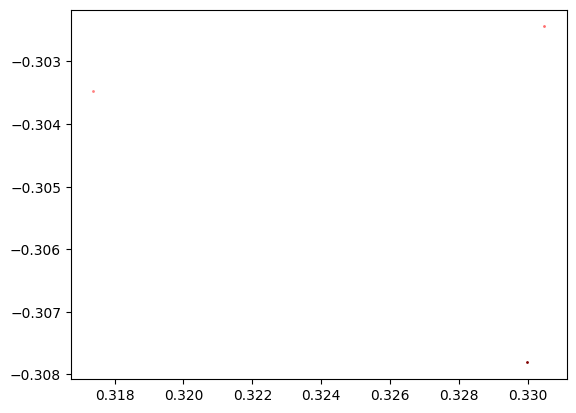

In [10]:
norm = mpl.colors.Normalize(vmin=-20, vmax=10)
cmap = cm.seismic
m = cm.ScalarMappable(norm=norm, cmap=cmap)
colors = [m.to_rgba(val) for val in meanCurvatures]
for i, point in enumerate(tqdm(full_2D_positions[:100])):
    plt.scatter(point[0], point[1], color = colors[i], s = 1)

In [44]:
import pyvista as pv
import numpy as np
import numpy as np
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
import matplotlib as mpl 
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from pyvista import examples

def normalizeToUnitBox(mesh):
    bounds = mesh.bounds
    xlen = bounds[1] - bounds[0]
    ylen = bounds[3] - bounds[2]
    zlen = bounds[5] - bounds[4]
    max_length = max(xlen, ylen, zlen)
    center = mesh.center
    meshCentered = mesh.translate(-np.array(center), inplace=False)
    meshScaled = meshCentered.scale(1 / max_length, inplace=False)
    return meshScaled

mesh = pv.read('atestforsomething.stl')
normalizedMesh = normalizeToUnitBox(mesh)
fingerVector = np.array([0,1,0])
normal = fingerVector / np.linalg.norm(fingerVector)
a = mesh.center + normal * mesh.length / 3.0
b = mesh.center - normal * mesh.length / 3.0
n_slices = 20
line = pv.Line(a, b, n_slices)
slices = pv.MultiBlock()
for point in line.points:
    slices.append(mesh.slice(normal=normal, origin=point))

norm = mpl.colors.Normalize(vmin=0, vmax=n_slices)
cmap = mpl.cm.get_cmap('Blues')
p = pv.Plotter()
p.add_mesh(mesh.outline())
for i in range(len(slices)):
    if len(slices[i].points) != 0:
        p.add_mesh(slices[i], opacity=1, color = cmap(norm(len(slices)-i)))
p.show()

C:\Users\Katie\AppData\Local\Temp\ipykernel_10592\839757694.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('Blues')


Widget(value="<iframe src='http://localhost:63593/index.html?ui=P_0x24b9fc2e9e0_69&reconnect=auto' style='widt…

In [24]:
import pyvista as pv
import numpy as np
import numpy as np
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
import matplotlib as mpl 
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from pyvista import examples
from tqdm import tqdm 

totalMesh = pv.read("imageAnalysisGeneration/totalStruct.stl")
socketMesh = pv.read("imageAnalysisGeneration/socketStruct.stl")
fingersMesh = pv.read("imageAnalysisGeneration/fingerStruct.stl")
p = pv.Plotter()
# p.add_mesh(socketMesh)
p.add_mesh(fingersMesh)
fingerVector = [12,50,0]
origin = [0, 90, 0]
def selectTopPoints(mesh, fingerVector:list, origin:list):
    selectedPointId = []
    normal = np.array(fingerVector)
    normal = normal/np.linalg.norm(normal)
    for i, point in enumerate(mesh.points):
        if np.dot(np.array(point)-np.array(origin), normal) > 0:
            selectedPointId.append(i)
    return mesh.extract_points(selectedPointId)

def moveToClosestFinger(socketPortion, fingerMeshes):
    normals = socketPortion.point_normals
    for idx, point1 in enumerate(socketPortion.points):
        closestPoint = fingerMeshes.points[0]
        closestDistance = np.linalg.norm(np.array(closestPoint)-np.array(point1)) 
        for point2 in fingerMeshes.points:
            currDistance = np.linalg.norm(np.array(point2)-np.array(point1))
            if currDistance < closestDistance:
                closestPoint = point2
                closestDistance = currDistance
        u = np.array(point1)-np.array(closestPoint)
        v = np.array(normals[idx])
        proj = np.dot(u,v)/(np.lingalg.norm(v)**2)*np.v
        socketPortion.points[idx] = point1+proj

extracted = selectTopPoints(socketMesh, fingerVector, origin)
moveToClosestFinger(extracted, fingersMesh)
p.add_mesh(extracted)
p.show()

TypeError: SetPassThroughPointIds argument 1: 'list' object cannot be interpreted as an integer

In [2]:
import pyvista as pv
import numpy as np
import numpy as np
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
import matplotlib as mpl 
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from pyvista import examples
from tqdm import tqdm 

totalMesh = pv.read("imageAnalysisGeneration/totalStruct.stl")
socketMesh = pv.read("imageAnalysisGeneration/socketStruct.stl")
fingersMesh = pv.read("imageAnalysisGeneration/fingerStruct.stl")
fingerVector = [12,50,0]
def selectPoints(socketMesh, fingerVector:list, fingerJointOrigin:list):
    point, idx = socketMesh.ray_trace(fingerJointOrigin, [fingerJointOrigin[i]-fingerVector[i] for i in range(3)], first_point=True)
    selectingSphere = pv.Sphere(radius=5, center = point)
    # selectedPoints = socketMesh.extract_points(socketMesh.select_enclosed_points(selectingSphere)['SelectedPoints'].view(bool))
    selectedIds = socketMesh.select_enclosed_points(selectingSphere)['SelectedPoints'].view(bool)
    finalSelectedIDs = []
    for i in range(len(selectedIds)):
        if selectedIds[i]:
            if i > len(socketMesh.points)/2:
                finalSelectedIDs.append(i)
            else:
                print("BRUH")

    return socketMesh.extract_points(finalSelectedIDs)

def moveToClosestFinger(socketPortion, fingerMeshes):
    normals = socketPortion.point_normals
    for idx, point1 in enumerate(socketPortion.points):
        closestPoint = fingerMeshes.points[0]
        closestDistance = np.linalg.norm(np.array(closestPoint)-np.array(point1)) 
        for point2 in fingerMeshes.points:
            currDistance = np.linalg.norm(np.array(point2)-np.array(point1))
            if currDistance < closestDistance:
                closestPoint = point2
                closestDistance = currDistance
        u = np.array(point1)-np.array(closestPoint)
        v = np.array(normals[idx])
        proj = np.dot(u,v)/(np.lingalg.norm(v)**2)*np.v
        socketPortion.points[idx] = point1+proj

extracted = selectPoints(socketMesh, fingerVector, fingersMesh.center)
print(extracted)
# moveToClosestFinger(extracted, fingersMesh)
# p.add_mesh(extracted)
p = pv.Plotter()
p.add_mesh(socketMesh, style = "wireframe")
p.add_mesh(fingersMesh)
p.add_points(extracted, color = "g")
p.show()

UnstructuredGrid (0x1d4bf185c00)
  N Cells:    1283
  N Points:   711
  X Bounds:   -1.676e+01, -6.111e+00
  Y Bounds:   9.350e+01, 9.859e+01
  Z Bounds:   -3.036e+01, -1.957e+01
  N Arrays:   2


Widget(value="<iframe src='http://localhost:54934/index.html?ui=P_0x1d4bafe7f40_1&reconnect=auto' style='width…

In [13]:
totalMesh = pv.read("imageAnalysisGeneration/totalStruct.stl")
smooth = totalMesh.smooth_taubin(n_iter=100, pass_band = 0.5)
smooth.plot()

Widget(value="<iframe src='http://localhost:55650/index.html?ui=P_0x281e07f9360_7&reconnect=auto' style='width…

In [7]:
import pyvista as pv
import numpy as np
import numpy as np
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
import matplotlib as mpl 
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from pyvista import examples
totalMesh = pv.read("imageAnalysisGeneration/totalStruct.stl")
def normalizeToUnitBox(totalMesh, socketMesh, fingerMesh):
    bounds = totalMesh.bounds
    xlen = bounds[1] - bounds[0]
    ylen = bounds[3] - bounds[2]
    zlen = bounds[5] - bounds[4]
    max_length = max(xlen, ylen, zlen)
    center = totalMesh.center
    totalMeshCentered = totalMesh.translate(-np.array(center), inplace=False)
    totalMeshScaled = totalMeshCentered.scale(1 / max_length, inplace=False)

    socketMeshCentered = socketMesh.translate(-np.array(center), inplace=False)
    socketMeshScaled = socketMeshCentered.scale(1 / max_length, inplace=False)

    fingerMeshCentered = fingerMesh.translate(-np.array(center), inplace=False)
    fingerMeshScaled = fingerMeshCentered.scale(1 / max_length, inplace=False)
    return [totalMeshScaled, socketMeshScaled, fingerMeshScaled]

totalMesh = pv.read("imageAnalysisGeneration/totalStruct.stl")
socketMesh = pv.read("imageAnalysisGeneration/socketStruct.stl")
fingersMesh = pv.read("imageAnalysisGeneration/fingerStruct.stl")

normalizedTotal, normalizedSocket, normalizedFingers  = normalizeToUnitBox(totalMesh, socketMesh, fingersMesh)
fingerVector = np.array([0,1,0])
normal = fingerVector / np.linalg.norm(fingerVector)
a = normalizedTotal.center + normal * normalizedTotal.length / 3.0
b = normalizedTotal.center - normal * normalizedTotal.length / 3.0
n_slices = 100
line = pv.Line(a, b, n_slices)
slicesSocket = pv.MultiBlock()
slicesFingers = pv.MultiBlock()
for point in line.points:
    slicesSocket.append(normalizedSocket.slice(normal=normal, origin=point))
    slicesFingers.append(normalizedFingers.slice(normal=normal, origin=point))

norm = mpl.colors.Normalize(vmin=0, vmax=n_slices)
cmapSocket = mpl.cm.get_cmap('Blues')
cmapFinger = mpl.cm.get_cmap('Reds')
p = pv.Plotter()
for i in range(n_slices):
    if len(slicesSocket[i].points) != 0:
        p.add_mesh(slicesSocket[i], opacity=1, color = cmapSocket(norm(n_slices-i)))
    if len(slicesFingers[i].points) != 0:
        p.add_mesh(slicesFingers[i], opacity=1, color = cmapFinger(norm(n_slices-i)))

p.camera_position = [(0,2,0), (0,0,0), (0,0,-1)]
p.camera_set = True 
p.show()
p.screenshot('testimage3.png')

C:\Users\Katie\AppData\Local\Temp\ipykernel_2416\2942321406.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmapSocket = mpl.cm.get_cmap('Blues')
C:\Users\Katie\AppData\Local\Temp\ipykernel_2416\2942321406.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmapFinger = mpl.cm.get_cmap('Reds')


Widget(value="<iframe src='http://localhost:55650/index.html?ui=P_0x281b8df6890_2&reconnect=auto' style='width…

pyvista_ndarray([[[255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255],
                  ...,
                  [255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255]],

                 [[255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255],
                  ...,
                  [255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255]],

                 [[255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255],
                  ...,
                  [255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255]],

                 ...,

                 [[255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255],
                  ...,
                  [255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255]],

                 [[255, 255, 255],
  

In [6]:
import pyvista as pv
import numpy as np
import numpy as np
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
import matplotlib as mpl 
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from pyvista import examples

def normalizeToUnitBox(totalMesh, socketMesh, fingerMesh):
    bounds = totalMesh.bounds
    xlen = bounds[1] - bounds[0]
    ylen = bounds[3] - bounds[2]
    zlen = bounds[5] - bounds[4]
    max_length = max(xlen, ylen, zlen)
    center = totalMesh.center
    totalMeshCentered = totalMesh.translate(-np.array(center), inplace=False)
    totalMeshScaled = totalMeshCentered.scale(1 / max_length, inplace=False)

    socketMeshCentered = socketMesh.translate(-np.array(center), inplace=False)
    socketMeshScaled = socketMeshCentered.scale(1 / max_length, inplace=False)

    fingerMeshCentered = fingerMesh.translate(-np.array(center), inplace=False)
    fingerMeshScaled = fingerMeshCentered.scale(1 / max_length, inplace=False)
    return [totalMeshScaled, socketMeshScaled, fingerMeshScaled]

totalMesh = pv.read("imageAnalysisGeneration/totalStruct.stl")
socketMesh = pv.read("imageAnalysisGeneration/socketStruct.stl")
fingersMesh = pv.read("imageAnalysisGeneration/fingerStruct.stl")
# mesh = pv.read('firsttestofnewmissinggeo.stl')
normalizedTotal, normalizedSocket, normalizedFingers  = normalizeToUnitBox(totalMesh, socketMesh, fingersMesh)
fingerVector = [0,1,0]
normal = np.array(fingerVector) / np.linalg.norm(np.array(fingerVector))
a = normalizedTotal.center + normal * normalizedTotal.length / 3.0
b = normalizedTotal.center - normal * normalizedTotal.length / 3.0


xSlices = 8
ySlices = 8

n_slices = xSlices*ySlices
line = pv.Line(a, b, n_slices)
slicesSocket = pv.MultiBlock()
slicesFingers = pv.MultiBlock()
for point in line.points:
    slicesSocket.append(normalizedSocket.slice(normal=normal, origin=point))
    slicesFingers.append(normalizedFingers.slice(normal=normal, origin=point))

norm = mpl.colors.Normalize(vmin=0, vmax=n_slices)
cmap = mpl.cm.get_cmap('Blues')
p = pv.Plotter()
p.add_mesh(normalizedTotal.outline())

p = pv.Plotter(shape=(xSlices, ySlices))
for x in range(xSlices):
    for y in range(ySlices):
        p.subplot(x, y)
        if len(slicesSocket[x*ySlices + y].points) != 0:
            # p.add_mesh(slices[x*ySlices + y], opacity=1, color = cmap(norm(len(slices)-(x*ySlices + y))))
            p.add_mesh(slicesSocket[x*ySlices + y], opacity=1, color = "Blue")
        if len(slicesFingers[x*ySlices + y].points) != 0:
            p.add_mesh(slicesFingers[x*ySlices + y], opacity=1, color = "Red")
        p.add_text(f"Layer: {(x)*(ySlices)+(y+1)}", font_size=12)
        p.camera_position = [(0,1,0), (0,0,0), (0,0,-1)]
        p.camera_set = True 

p.show()
p.screenshot('testimage2.png')

C:\Users\Katie\AppData\Local\Temp\ipykernel_2416\4227212618.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('Blues')


Widget(value="<iframe src='http://localhost:55650/index.html?ui=P_0x281da37d300_1&reconnect=auto' style='width…

pyvista_ndarray([[[  0,   0,   0],
                  [  0,   0,   0],
                  [  0,   0,   0],
                  ...,
                  [  0,   0,   0],
                  [  0,   0,   0],
                  [  0,   0,   0]],

                 [[  0,   0,   0],
                  [255, 255, 255],
                  [255, 255, 255],
                  ...,
                  [255, 255, 255],
                  [255, 255, 255],
                  [  0,   0,   0]],

                 [[  0,   0,   0],
                  [255, 255, 255],
                  [255, 255, 255],
                  ...,
                  [255, 255, 255],
                  [255, 255, 255],
                  [  0,   0,   0]],

                 ...,

                 [[  0,   0,   0],
                  [255, 255, 255],
                  [255, 255, 255],
                  ...,
                  [255, 255, 255],
                  [255, 255, 255],
                  [  0,   0,   0]],

                 [[  0,   0,   0],
  